In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [57]:
# Load dataset
data = np.load("./drive/MyDrive/FYP/dataset.npz")

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
class_names = data['class_names']

print(f"Loaded dataset:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Loaded dataset:
X_train shape: (16006, 64, 64, 3)
X_test shape: (4002, 64, 64, 3)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

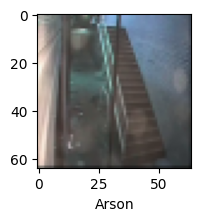

In [58]:
def plot_sample(X,y,index):
    plt.figure(figsize=(3,2))
    plt.imshow(X[index])
    plt.xlabel(class_names[y[index]])

plot_sample(X_train,y_train,1)

In [28]:
def create_hybrid_vit_model(input_shape=(64, 64, 3), num_classes=14):
    # 1. CNN Feature Extractor
    cnn_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    cnn_features = layers.Dense(128, activation='relu')(x)

    # 2. Transformer Input: Patch Embeddings
    image_size = input_shape[0]
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64

    # Adjust the CNN output to match num_patches * projection_dim
    adjusted_dim = num_patches * projection_dim
    cnn_features = layers.Dense(adjusted_dim, activation='relu')(cnn_features)

    # Reshape into patches
    patches = layers.Reshape((num_patches, projection_dim))(cnn_features)

    # 3. Positional Encoding
    position_embedding = tf.constant(tf.random.uniform((1, num_patches, projection_dim)))
    embedded_patches = patches + position_embedding

    # 4. Transformer Layers
    for _ in range(8):  # 8 transformer layers
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim)(
            embedded_patches, embedded_patches
        )
        attention_output = layers.Add()([attention_output, embedded_patches])  # Residual connection
        attention_output = layers.LayerNormalization()(attention_output)

        mlp_output = layers.Dense(projection_dim * 2, activation='relu')(attention_output)
        mlp_output = layers.Dense(projection_dim)(mlp_output)
        embedded_patches = layers.Add()([mlp_output, attention_output])  # Residual connection
        embedded_patches = layers.LayerNormalization()(embedded_patches)

    # 5. Classification Head
    representation = layers.GlobalAveragePooling1D()(embedded_patches)
    mlp_head = layers.Dense(2048, activation='relu')(representation)
    mlp_head = layers.Dense(1024, activation='relu')(mlp_head)
    output = layers.Dense(num_classes, activation='softmax')(mlp_head)

    hybrid_vit_model = Model(inputs=cnn_input, outputs=output, name="Hybrid_CNN_ViT")
    return hybrid_vit_model


In [34]:
# Instantiate and compile the model
hybrid_vit = create_hybrid_vit_model(input_shape=(64, 64, 3), num_classes=len(class_names))
hybrid_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


# Summarize the model
hybrid_vit.summary()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = hybrid_vit.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)



Model: "Hybrid_CNN_ViT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 62, 62, 32)     │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 31, 31, 32)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 29, 29, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 14, 14, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12544)          │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 128)            │      1,605,760 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_64 (Dense)          │ (None, 6400)           │        825,600 │ dense_63[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 100, 64)        │              0 │ dense_64[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_51 (Add)              │ (None, 100, 64)        │              0 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_24   │ (None, 100, 64)        │         66,368 │ add_51[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_51[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_52 (Add)              │ (None, 100, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ add_51[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_48    │ (None, 100, 64)        │            128 │ add_52[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_65 (Dense)          │ (None, 100, 128)       │          8,320 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_66 (Dense)          │ (None, 100, 64)        │          8,256 │ dense_65[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_53 (Add)              │ (None, 100, 64)        │              0 │ dense_66[0][0],        │
│                           │                        │                │ layer_normalization_4… │
├──────────────────────

 Total params: 5,361,998 (20.45 MB)

 Trainable params: 5,361,998 (20.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


501/501 ━━━━━━━━━━━━━━━━━━━━ 84s 103ms/step - accuracy: 0.0322 - loss: 2.7122 - val_accuracy: 0.0117 - val_loss: 2.6343
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.0333 - loss: 2.6345 - val_accuracy: 0.0117 - val_loss: 2.6412
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 40s 61ms/step - accuracy: 0.0221 - loss: 2.6447 - val_accuracy: 0.0267 - val_loss: 2.6384
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.0254 - loss: 2.6543 - val_accuracy: 0.0385 - val_loss: 2.6387


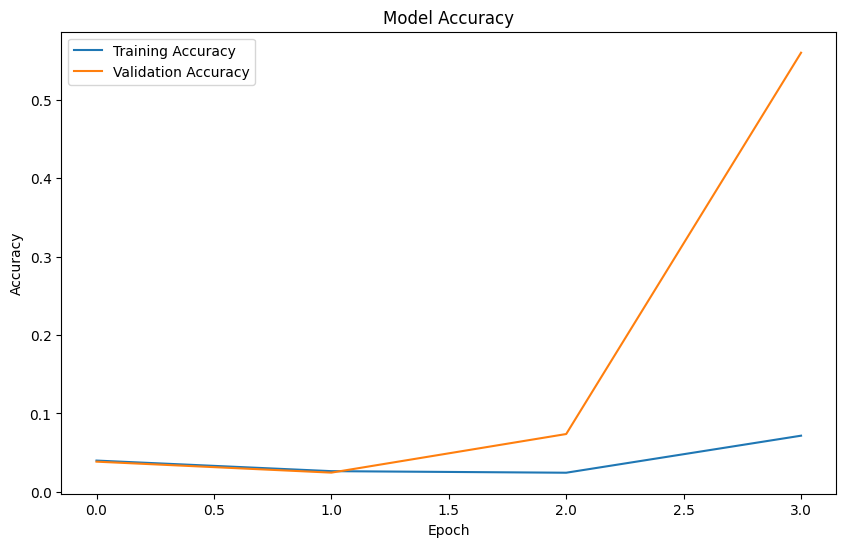

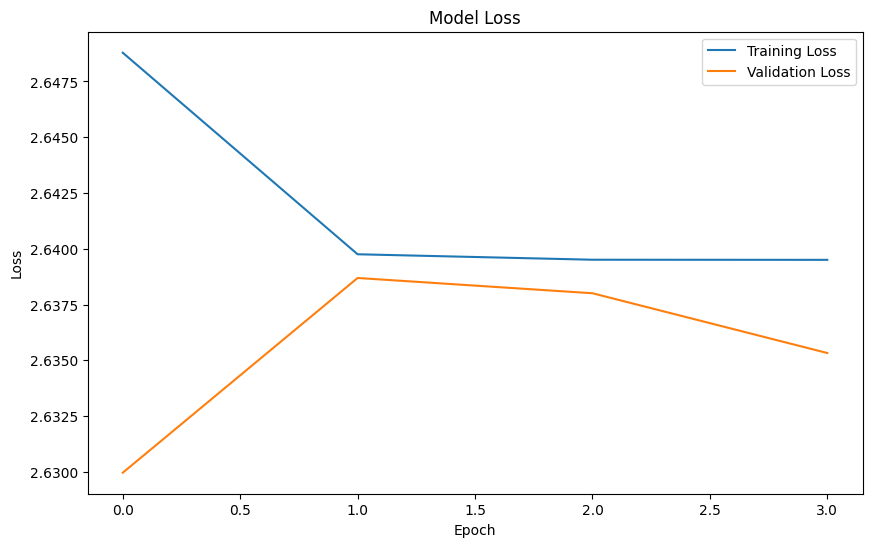

In [30]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


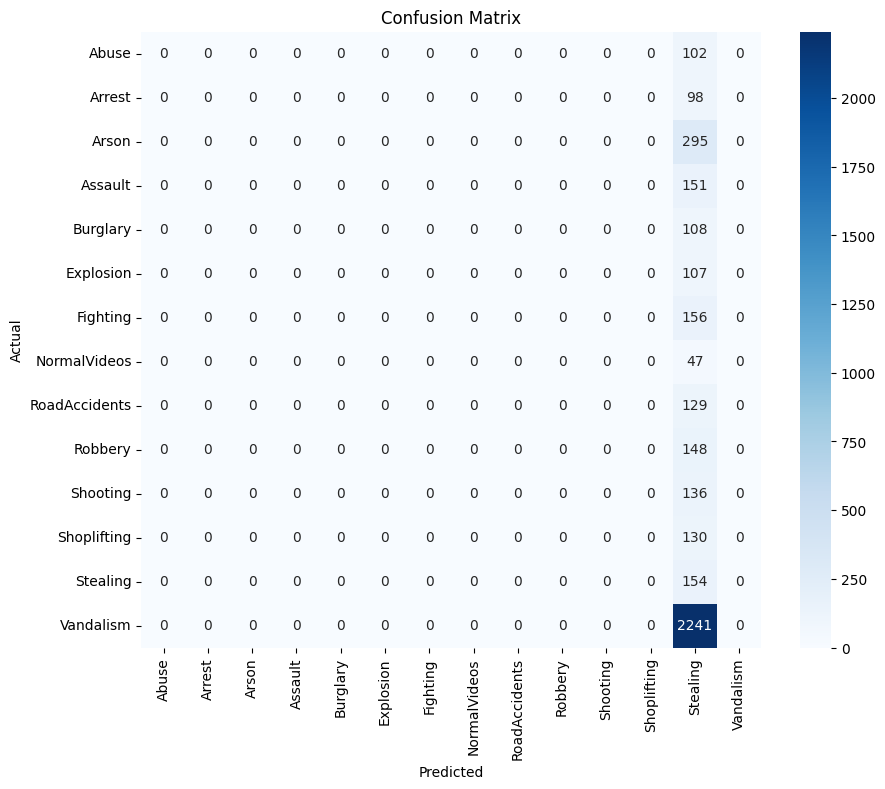

classification_report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.00      0.00      0.00        98
           2       0.00      0.00      0.00       295
           3       0.00      0.00      0.00       151
           4       0.00      0.00      0.00       108
           5       0.00      0.00      0.00       107
           6       0.00      0.00      0.00       156
           7       0.00      0.00      0.00        47
           8       0.00      0.00      0.00       129
           9       0.00      0.00      0.00       148
          10       0.00      0.00      0.00       136
          11       0.00      0.00      0.00       130
          12       0.04      1.00      0.07       154
          13       0.00      0.00      0.00      2241

    accuracy                           0.04      4002
   macro avg       0.00      0.07      0.01      4002
weighted avg       0.00      0.04      0.00      4002



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# Generate predictions and convert them to class indices
y_pred = hybrid_vit.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("classification_report\n", classification_report(y_test, y_pred_classes))


In [32]:
# Save the model
hybrid_vit.save('./drive/MyDrive/FYP/hybrid_vit_model.h5')


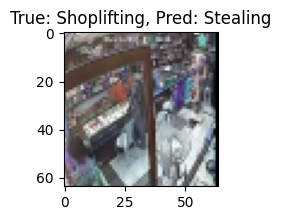

In [52]:
def plot_sample_with_prediction(X, y_true, y_pred, index):
    plt.figure(figsize=(3, 2))
    plt.imshow(X[index])
    plt.title(f"True: {class_names[y_true[index]]}, Pred: {class_names[y_pred[index]]}")
    plt.show()

plot_sample_with_prediction(X_test, y_test, y_pred_classes, 661)
